# Dr LIM - Dimensionality reduction by Learning Invariant Mapping

- This paper (similar to TSNE) proposes an alternative method to achieve dimensionality reduction

In [1]:
from __future__ import print_function
from functools import reduce

import numpy as np

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from matplotlib import pyplot as plt

from image_utilities import plot_images

## CNN used in the paper 

![CNN architecture](./images/cnn.png)

### Torch implementation 

#### Forward

In [2]:
class DrlimCNN(nn.Module):
    def __init__(self, n_lower_dim=2):
        super(DrlimCNN, self).__init__()
        
        # Layer 1:
        # n_input_channel = 1
        # n_output_channel = 15
        # Kernel Size = 5 for padding = 0, stride = 1
        k_size = 5
        in_channels = 1
        out_channels = 15 
        self.layer_1 = nn.Conv2d(in_channels, out_channels, k_size)
        
        # Layer 2: Subsampling - Maxpooling
        # Kernel Size = 15  for padding=0 and stride = 1
        k_size = 15
        self.max_pooling = nn.MaxPool2d(k_size, stride=1)
        
        # Layer 3: Conv layer
        # n_input_channel = 15
        # n_output_channel = 30
        # Kernel size = 10
        in_channels = 15
        out_channels = 30
        k_size = 10
        self.layer_3 = nn.Conv2d(in_channels, out_channels, k_size)
        
        # Layer 4: Fully connected
        self.output_layer = nn.Linear(30, n_lower_dim)
        
        # Relu
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Add relu on top of conv layer
        x = self.layer_1(x)
        x = self.relu(x)
        
        # Maxpool 
        x = self.max_pooling(x)
        
        # Another conv
        x = self.layer_3(x)
        
        # Get the size except for batch
        num_flat_features = reduce(lambda x, y: x * y, x.shape[1:])
        
        # Flatten
        x = x.reshape(-1, num_flat_features)
        
        # Fully connected 
        x = self.output_layer(x)
        
        return x
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

net = DrlimCNN()

# Enable GPU
net.to(device)
net.cuda()

cuda:0


DrlimCNN(
  (layer_1): Conv2d(1, 15, kernel_size=(5, 5), stride=(1, 1))
  (max_pooling): MaxPool2d(kernel_size=15, stride=1, padding=0, dilation=1, ceil_mode=False)
  (layer_3): Conv2d(15, 30, kernel_size=(10, 10), stride=(1, 1))
  (output_layer): Linear(in_features=30, out_features=2, bias=True)
  (relu): ReLU()
)

#### Backward

##### Define contrastive loss function

In [3]:
def contrastive_loss(output_1, output_2, 
            target_1, target_2):
    
    # TODO:
    #    if target_1 == target_2:
    #        y = torch.zeros_like(output_1, requires_grad=True)
    #    else:
    #        y = torch.ones_like(output_1, requires_grad=True)
        
    y = 1 - torch.eq(target_1, target_2).int()
        
    distance = torch.norm(output_1 - output_2, dim=1)
    
    # Similar loss
    ls = torch.pow(distance, 2)
    
    # Dissimilar loss
    m = 10
    ld = torch.max(torch.zeros_like(distance), m - distance)
    ld = torch.pow(ld, 2)
    
    loss = torch.mean((1 - y) * ls + y * ld)
    
    return loss

### Test the network once

In [4]:
test = False 
if test:
    # Test Code
    input_1 = torch.randn(1, 1, 28, 28)
    input_2 = torch.randn(1, 1, 28, 28)

    out_1 = net(input_1.cuda())
    out_2 = net(input_2.cuda())
    out_1 = out_1.requires_grad_(True)
    out_2 = out_2.requires_grad_(True)

    print("Before:")
    print(net.output_layer.weight.grad)
    loss = contrastive_loss(out_1, out_2,
                            0, 0)
    print(loss)
    loss.backward()
    print("After:")
    print(net.output_layer.weight.grad)

## Load Data

In [5]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,))
                               ])),
    batch_size=batch_size_train, shuffle=True)

## Train

In [6]:
target_1 = 9 
target_2 = 4

In [7]:
n_epochs = 100
n_random_repeat = 2
optimizer = optim.Adam(net.parameters(), lr=3.e-4)

all_data = []
all_target = []

for batch_idx, (data, target) in enumerate(train_loader):
    # Choose only either `target_1` or `target_2` 
    filter_index = ((target == target_1) | (target == target_2))
    all_data += data[filter_index].numpy().tolist()
    all_target += target[filter_index].numpy().tolist()
    
all_data.pop()
all_target.pop()
batch_size = 30

all_data = np.array(all_data).reshape(11790, 1, 28, 28)
all_target = np.array(all_target).reshape(11790, 1)

all_data = np.array(all_data).reshape(-1, 30, 28, 28)
all_target = np.array(all_target).reshape(-1, 30)

In [8]:
loss_cache = []
for epoch in range(n_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(all_data): 
        target = torch.tensor(all_target[i], dtype=torch.float32)
        data  = torch.tensor(data, dtype=torch.float32)
        data = torch.unsqueeze(data, 1).to(device)
        
        input_data, label = data, target
        
        for r in range(n_random_repeat):
            # Split this batch into two groups and compute contrast loss between them
            out = net(input_data)
            sample = np.random.randint(0, 30, 15).tolist()
            out_1, label_1 = out[sample, :], target[sample]
            sample = np.random.randint(0, 30, 15).tolist()
            out_2, label_2 = out[sample, :], target[sample]

            # Loss - against target_1 and target_2
            loss = contrastive_loss(out_1.to('cpu'), out_2.to('cpu'),
                                    label_1, label_2)

            # Back prop
            loss.backward()
            optimizer.step()
            loss_cache.append(loss.detach())

        # print statistics
        running_loss += loss.item()
        if i % 20 == 0:    # print every 2000 mini-batches
            print('[{}, {}] loss: {} \r'.format(epoch + 1, i + 1, running_loss / 2000), end="")
            running_loss = 0.0
            
        optimizer.zero_grad()
    
print("")

print('Finished Training')

[100, 381] loss: 0.021100037518888712 
Finished Training


Text(0.5, 0, 'Steps')

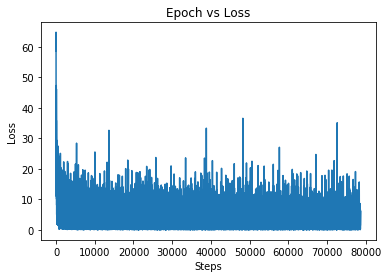

In [9]:
plt.plot(list(range(len(loss_cache))), loss_cache)
plt.title("Epoch vs Loss")
plt.ylabel('Loss')
plt.xlabel('Steps')

In [33]:
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=False, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,))
                               ])),
    batch_size=batch_size_test, shuffle=True)
    
data_x = []
data_y = []
data_manifold = []
for i in range(10):
    filter_index = (target == i)
    temp_data = data[filter_index].numpy().squeeze()
    
    # Get manifold output
    temp_data = torch.tensor(temp_data).unsqueeze(1).to(device)
    out = net(temp_data)
    out = out.clone()
    out = out.cpu().detach().numpy().squeeze()
    
    # Prepare data to plot
    data_x.append(out[:, 0])
    data_y.append(out[:, 1])

In [47]:
def plot_graphs(one=False, two=False, 
                three=False, four=True, 
                five=False, six=False, 
                seven=False, eight=False, 
                nine=True, zero=False):
    
    global data_x, data_y
    plt.figure(figsize=(14, 10))
    
    mapping = {0:  "zero", 1: "one",
               2: "two", 3: "three", 
               4: "four", 5: "five",
               6: "six", 7: "seven",
               8: "eight", 9: "nine"}
    for k in mapping:
        if locals()[mapping[k]]:
            plt.scatter(data_x[k], data_y[k], label="Number {}".format(k), alpha=0.5)
    plt.title("Lower dimensional map - Number 9 and Number 4")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()

#### Simple Plot

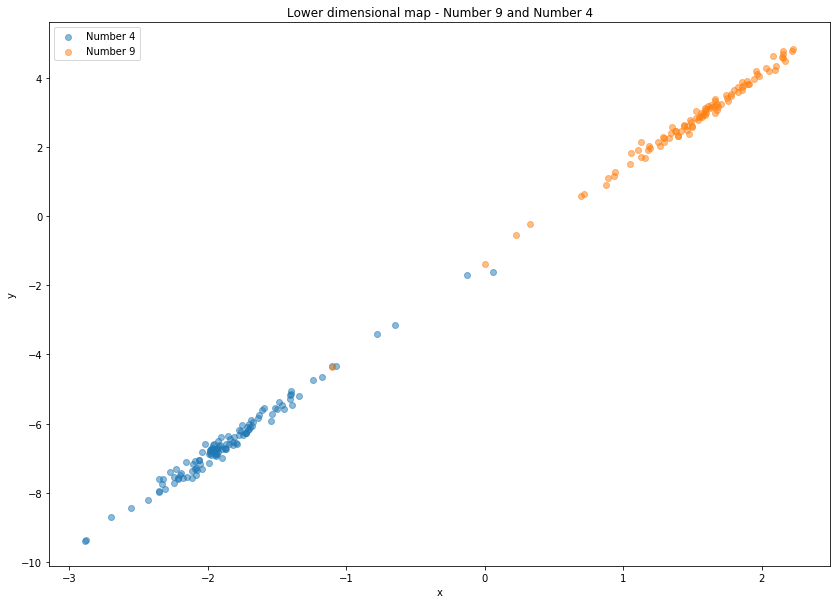

In [48]:
plot_graphs(nine=True, four=True)

### Interactive Graph

In [57]:
w = interactive(plot_graphs)

In [59]:
display(w)